# Imports

In [1]:
from Models import *
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import random
from helperFunctions import *
from torch import tensor
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import random
import torch
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
# If we have a GPU available, we'll set our device to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


# Data Pre-Processing

In [3]:
# Load XDF Files

"""
Files that work
part_P001_block_S001.xdf # This does not have the cross hair
part_P002_block_S001.xdf # These have cross hairs
part_P003_block_S001.xdf 

These experiments consist of the user looking at faces vs landscape as labeled by the Markers. 
In the more recent experiments, there are also cross hairs for the subject to fixate on before 
each new image is shown. 
"""
filename2 = "part_P002_block_S001"
XDF_Path2 = "./data/"+filename2+".xdf"
XDF_Data2 = loadxdf(XDF_Path2)

filename3 = "part_P003_block_S001"
XDF_Path3 = "./data/"+filename3+".xdf"
XDF_Data3 = loadxdf(XDF_Path3)

filename1 = "part_P001_block_S001"
XDF_Path1 = "./data/"+filename1+".xdf"
XDF_Data1 = loadxdf(XDF_Path1)

In [4]:
first_trial = getMarkerBoundSingleMarkerData('NewImageStart', 'NewImageEnd', XDF_Data1, go_backward=False)
second_trial = getMarkerBoundSingleMarkerData('NewImageStart', 'NewImageEnd', XDF_Data2, go_backward=False)
third_trial = getMarkerBoundSingleMarkerData('NewImageStart', 'NewImageEnd', XDF_Data3, go_backward=False)

In [5]:
def filterDataForPipline(data):
    filteredData = []
    for i in range(len(data[0])):
        filterData = [0, []]
        if 'Face' in data[0][i].get('markers').get('data'):
            filterData[0] = 1
        filterData[1] = data[0][1].get('eeg').get('data')
        filteredData.append(filterData)
    return filteredData

In [6]:
data_1 = filterDataForPipline(first_trial)
data_2 = filterDataForPipline(second_trial)
data_3 = filterDataForPipline(third_trial)
# all_data = (data_1, data_2, data_3)
all_data = (data_1, data_2)

In [7]:
for d in all_data:
    print('Sequences: %d, Size of first sequence: %d, Size of data per timestamp: %d' % (len(d), len(d[0][1]), len(d[0][1][0])))
print('Sample row:', data_3[3])

Sequences: 10, Size of first sequence: 232, Size of data per timestamp: 4
Sequences: 20, Size of first sequence: 166, Size of data per timestamp: 4
Sample row: [0, array([[ -13.502434,   10.158206,  -36.641342,    0.      ],
       [  -9.502434,   10.158206,  -36.641342,    0.      ],
       [  -9.502434,   10.158206,  -36.641342,    0.      ],
       [  -9.502434,   10.158206,  -36.641342,    0.      ],
       [  -9.502434,   10.158206,  -36.641342,    0.      ],
       [  -9.502434,   10.158206,  -36.641342,    0.      ],
       [  -9.502434,   10.158206,  -36.641342,    0.      ],
       [  -9.502434,   10.158206,  -36.641342,    0.      ],
       [  -6.502434,   10.158206,  -36.641342,    0.      ],
       [ 229.49756 ,   -2.841794,  -32.641342,    0.      ],
       [ 142.49756 ,   -2.841794,  -32.641342,    0.      ],
       [ 142.49756 ,   -2.841794,  -32.641342,    0.      ],
       [ 142.49756 ,   -2.841794,  -32.641342,    0.      ],
       [ 142.49756 ,   -2.841794,  -32.6413

In [8]:
labels = list()
data = list()

for d in all_data:
    sample_data = list()
    for l, s in d:
        labels.append(l)
        data.append(np.array(s))

In [9]:
class EEGDataset(Dataset):
    def __init__(self, labels, data, dims, device):
        self.labels = np.array(labels)
        self.data = data
        self.dims = dims
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        
        sample = dict()
        l = tensor(self.labels[idx]).to(self.device)
        # Get only the columns of the data we need
        d = tensor(self.data[idx][ : , self.dims]).to(self.device)
        
        return (l, d)

In [ ]:
batch_size = 5

In [10]:
dataset = EEGDataset(labels=labels, data=data, dims=0, device=device)

for i in range(len(dataset)):
    l, d = dataset[i]
    print(i, l.size(), d.size())
    
    if(i == 5):
        break

0 torch.Size([]) torch.Size([232])
1 torch.Size([]) torch.Size([232])
2 torch.Size([]) torch.Size([232])
3 torch.Size([]) torch.Size([232])
4 torch.Size([]) torch.Size([232])
5 torch.Size([]) torch.Size([232])


In [11]:
train_frac = 0.99
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=train_frac)
train_dataset = EEGDataset(data=train_data, labels=train_labels, dims=0, device=device)
test_dataset = EEGDataset(data=test_data, labels=test_labels, dims=0, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Setting Up NN Models

In [12]:
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

In [13]:
max_length = 0
min_length = 500
for l, d in train_dataloader:
    if d.size()[1] > max_length:
        max_length = d.size()[1]
    if d.size()[1] < min_length:
        min_length = d.size()[1]

In [14]:
min_length, max_length

(166, 232)

In [15]:
hidden_dim = 50
epochs = 100
lr = 0.1
input_size = 1
sequence_length = min_length

In [16]:
lstm = LSTM_Model(input_dim=input_size, hidden_dim=hidden_dim, num_classes=2, batch_size=batch_size, computing_device=device).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Train NN Models

In [17]:
train_losses = list()
lstm.init_hidden()

for epoch in tqdm(range(epochs), desc='Epoch'):
    random.shuffle(train_data)
    
    sum_loss = 0.0
    num_samp = 0
    
    for label, data in train_dataloader:
        lstm.hidden = (lstm.hidden[0].detach(), lstm.hidden[1].detach())
        label = label.long()
        data_len = data.size()[1]
        data = 
        data = data.reshape(-1, data_len, input_size).to(device)
        output = lstm(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        num_samp += 1
    
    train_losses.append(sum_loss / num_samp)

In [18]:
print(train_losses[0], train_losses[-1])

1.622643111080959 2.2722977667019286


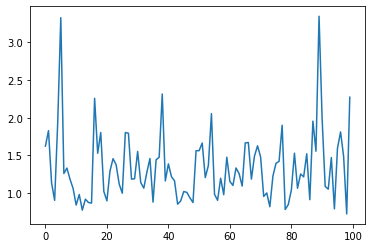

In [19]:
plt.plot(train_losses)
plt.show()

In [20]:
with torch.no_grad():
    accuracy = 0
    num_samp = 0
    
    for label, data in train_dataloader:
        lstm.hidden = (lstm.hidden[0].detach(), lstm.hidden[1].detach())
        label = label.long()
        data_len = data.size()[1]
        data = data.reshape(-1, data_len, input_size).to(device)
        output = torch.sigmoid(lstm(data)).tolist()[0]
        
        if output[0] > output[1]:
            result = 0
        else:
            result = 1
        accuracy += 1 if result == label else 0
        num_samp += 1
    
    print(accuracy / num_samp)


0.5172413793103449
